<a href="https://colab.research.google.com/github/plue1011/PyTorch/blob/master/practice/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 二値分類

In [0]:
import cv2
import os
import copy
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizers
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score

In [0]:
# 関数

## 学習の早期終了
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

## 1ステップ分の訓練のための関数
def train_step(x, t):
    model.train()  # モデルを訓練モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める
    optimizer.zero_grad()  # 勾配を初期化する
    loss.backward()  # 勾配を計算する
    optimizer.step()  # パラメータを更新する
    return loss, preds

## 1ステップ分の訓練のための関数
def val_step(x, t):
    model.eval()  # モデルを評価モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める    
    return loss, preds

## テストデータの評価関数
def test_step(x, t):
    return val_step(x, t)

In [4]:
# データの読み込み
root_path = '/content/drive/My Drive/study/CNN/dataset/CIFAR10'
train_set = torchvision.datasets.CIFAR10(root=root_path, train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root=root_path, train=False, download=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# 飛行機と車だけ抽出
train_set_class01 = []
train_labels = []
for data, label in train_set:
    if label == 0 or label == 1:
        train_set_class01.append(data)
        train_labels.append(label)

test_set_class01 = []
test_labels = []
for data, label in test_set:
    if label == 0 or label == 1:
        test_set_class01.append(data)
        test_labels.append(label)

## NN

In [0]:
#  transformの作成
transform = transforms.Compose(
    [transforms.ToTensor(),  # tensor型に変換
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 画像を正規化
     lambda x: x.view(-1)  # NNに入力するため、画像を二次元ではなく、一次元で考える
    ])

In [0]:
# Datasetの作成
class MyDataset(Dataset):
    def __init__(self, dataset, labels, transform=None):
        self.transform = transform
        self.dataset = dataset
        self.labels = labels
        self.data = []
        self.label = []
        for data, label in zip(self.dataset, self.labels):
            self.data.append(data) # 画像データ
            self.label.append(label) # ラベル

    def __len__(self):
        return len(self.label)

    # データをtransformで前処理してから返している
    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label =  self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label
    
train_dataset = MyDataset(train_set_class01, train_labels, transform)
test_dataset = MyDataset(test_set_class01, test_labels, transform)

In [0]:
# DataLoaderの作成
## 訓練データをさらに「訓練データ」と「検証データ」に分ける(検証データ!=テストデータ)
n_samples = len(train_dataset)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train
train_dataset, val_dataset = random_split(train_dataset, [n_train, n_val])

train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [0]:
# モデルの構築
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NN, self).__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.a = nn.Sigmoid()
        self.l2 = nn.Linear(hidden_dim, output_dim)
    
        self.layers = [self.l1, self.a, self.l2]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [0]:
input_dim = 3072  # 入力層の次元数(画像データを一次元に変換したときの次元数)
hidden_dim = 4  # 中間層の次元数(中間層のニューロン数)
output_dim = 2  # 出力層の次元数(車or飛行機のクラス数)

## モデルの構築
model = NN(input_dim, hidden_dim, output_dim)

# 誤差関数の定義
compute_loss = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), 
                            amsgrad=True)

In [0]:
# 学習
## 設定
epochs = 100  # エポック数を設定する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # cpuかgpuのどちらのデバイスを使っているかを代入する
hist = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
es = EarlyStopping(patience=10, verbose=1)  # 10回以上誤差が小さくならないと早期終了する

np.random.seed(123)
torch.manual_seed(123)

## モデルの学習
for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.

    # 訓練パート
    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # 検証パート
    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    # 学習状況を保存
    hist['loss'].append(train_loss)
    hist['accuracy'].append(train_acc)
    hist['val_loss'].append(val_loss)
    hist['val_accuracy'].append(val_acc)

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'
          ', val_loss: {:.3}, val_acc: {:.3f}'.format(
              epoch+1,
              train_loss,
              train_acc,
              val_loss,
              val_acc
          ))

    if es(val_loss):
        break

epoch: 1, loss: 0.543, acc: 0.780, val_loss: 0.495, val_acc: 0.807
epoch: 2, loss: 0.473, acc: 0.813, val_loss: 0.473, val_acc: 0.802
epoch: 3, loss: 0.44, acc: 0.823, val_loss: 0.446, val_acc: 0.814
epoch: 4, loss: 0.42, acc: 0.831, val_loss: 0.439, val_acc: 0.813
epoch: 5, loss: 0.405, acc: 0.833, val_loss: 0.432, val_acc: 0.809
epoch: 6, loss: 0.392, acc: 0.833, val_loss: 0.432, val_acc: 0.811
epoch: 7, loss: 0.384, acc: 0.838, val_loss: 0.424, val_acc: 0.810
epoch: 8, loss: 0.375, acc: 0.842, val_loss: 0.424, val_acc: 0.815
epoch: 9, loss: 0.369, acc: 0.841, val_loss: 0.424, val_acc: 0.810
epoch: 10, loss: 0.361, acc: 0.843, val_loss: 0.433, val_acc: 0.809
epoch: 11, loss: 0.354, acc: 0.848, val_loss: 0.429, val_acc: 0.806
epoch: 12, loss: 0.35, acc: 0.851, val_loss: 0.43, val_acc: 0.808
epoch: 13, loss: 0.342, acc: 0.851, val_loss: 0.434, val_acc: 0.808
epoch: 14, loss: 0.336, acc: 0.856, val_loss: 0.425, val_acc: 0.810
epoch: 15, loss: 0.331, acc: 0.858, val_loss: 0.431, val_acc:

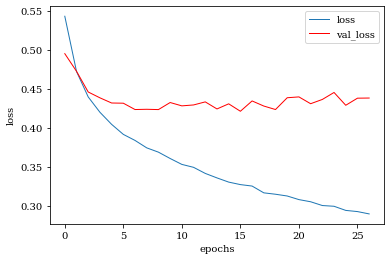

In [0]:
# モデルの評価

## 検証データの誤差の可視化
loss = hist['loss']
val_loss = hist['val_loss']

fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss, linewidth=1,
             label='loss')
plt.plot(range(len(val_loss)), val_loss,
             color='red', linewidth=1,
             label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [0]:
# 予測
test_loss = 0.
test_acc = 0.

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
        test_loss,
        test_acc
))

test_loss: 0.379, test_acc: 0.835


## NN_改良

In [0]:
# NNとの改良箇所
# ------------------------------------------------------------------ #
# モデルの構築
class DNN(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.b1 = nn.BatchNorm1d(hidden_dim)
        self.a1 = nn.ReLU()
        self.d1 = nn.Dropout(0.5)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.b2 = nn.BatchNorm1d(hidden_dim)
        self.a2 = nn.ReLU()
        self.d2 = nn.Dropout(0.5)
        self.l3 = nn.Linear(hidden_dim, hidden_dim)
        self.b3 = nn.BatchNorm1d(hidden_dim)
        self.a3 = nn.ReLU()
        self.d3 = nn.Dropout(0.5)
        self.l4 = nn.Linear(hidden_dim, output_dim)
    
        self.layers = [self.l1, self.b1, self.a1, self.d1,self.l2,self.b2, self.a2, self.d2,self.l3,self.b3, self.a3, self.d3, self.l4 ]

        for layer in self.layers:
            if type(layer) == nn.Linear:
                nn.init.kaiming_normal_(layer.weight)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

input_dim = 3072  # 入力層の次元数(画像データを一次元に変換したときの次元数)
hidden_dim = 200  # 中間層の次元数(中間層のニューロン数)
output_dim = 2  # 出力層の次元数(車or飛行機のクラス数)

# ------------------------------------------------------------------ #

## モデルの構築
model = DNN(input_dim, hidden_dim, output_dim)

# 誤差関数の定義
compute_loss = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), 
                            amsgrad=True)

In [0]:
# 学習
## 設定
epochs = 100  # エポック数を設定する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # cpuかgpuのどちらのデバイスを使っているかを代入する
hist = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
es = EarlyStopping(patience=10, verbose=1)  # 10回以上誤差が小さくならないと早期終了する

np.random.seed(123)
torch.manual_seed(123)

## モデルの学習
for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.

    # 訓練パート
    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # 検証パート
    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    # 学習状況を保存
    hist['loss'].append(train_loss)
    hist['accuracy'].append(train_acc)
    hist['val_loss'].append(val_loss)
    hist['val_accuracy'].append(val_acc)

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'
          ', val_loss: {:.3}, val_acc: {:.3f}'.format(
              epoch+1,
              train_loss,
              train_acc,
              val_loss,
              val_acc
          ))

    if es(val_loss):
        break

epoch: 1, loss: 0.588, acc: 0.720, val_loss: 0.387, val_acc: 0.826
epoch: 2, loss: 0.459, acc: 0.789, val_loss: 0.372, val_acc: 0.833
epoch: 3, loss: 0.407, acc: 0.817, val_loss: 0.351, val_acc: 0.843
epoch: 4, loss: 0.38, acc: 0.830, val_loss: 0.331, val_acc: 0.851
epoch: 5, loss: 0.354, acc: 0.844, val_loss: 0.34, val_acc: 0.850
epoch: 6, loss: 0.335, acc: 0.855, val_loss: 0.331, val_acc: 0.850
epoch: 7, loss: 0.329, acc: 0.858, val_loss: 0.324, val_acc: 0.856
epoch: 8, loss: 0.31, acc: 0.868, val_loss: 0.321, val_acc: 0.857
epoch: 9, loss: 0.305, acc: 0.873, val_loss: 0.325, val_acc: 0.860
epoch: 10, loss: 0.292, acc: 0.882, val_loss: 0.31, val_acc: 0.860
epoch: 11, loss: 0.281, acc: 0.884, val_loss: 0.313, val_acc: 0.864
epoch: 12, loss: 0.285, acc: 0.879, val_loss: 0.317, val_acc: 0.864
epoch: 13, loss: 0.272, acc: 0.887, val_loss: 0.305, val_acc: 0.870
epoch: 14, loss: 0.265, acc: 0.889, val_loss: 0.323, val_acc: 0.863
epoch: 15, loss: 0.258, acc: 0.895, val_loss: 0.324, val_acc:

In [0]:
# モデルの評価
## 検証データの誤差の可視化
loss = hist['loss']
val_loss = hist['val_loss']

fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss, linewidth=1,
             label='loss')
plt.plot(range(len(val_loss)), val_loss,
             color='red', linewidth=1,
             label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# 予測
test_loss = 0.
test_acc = 0.

In [0]:
for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
        test_loss,
        test_acc
))

## CNN

In [0]:
#  transformの作成
transform = transforms.Compose(
    [transforms.ToTensor(),  # tensor型に変換
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 画像を正規化
    ])

In [0]:
# Datasetの作成
class MyDataset(Dataset):
    def __init__(self, dataset, labels, transform=None):
        self.transform = transform
        self.dataset = dataset
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    # データをtransformで前処理してから返している
    def __getitem__(self, idx):
        out_data = self.dataset[idx]
        out_label =  self.labels[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label
    
train_dataset = MyDataset(train_set_class01, train_labels, transform)
test_dataset = MyDataset(test_set_class01, test_labels, transform)

In [0]:
# DataLoaderの作成
## 訓練データをさらに「訓練データ」と「検証データ」に分ける(検証データ!=テストデータ)
n_samples = len(train_dataset)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train
train_dataset, val_dataset = random_split(train_dataset, [n_train, n_val])

train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [0]:
# モデルの構築
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [0]:
# モデルの構築
model = CNN()

# 誤差関数の定義
compute_loss = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), 
                            amsgrad=True)

In [16]:
# 学習
## 設定
epochs = 100  # エポック数を設定する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # cpuかgpuのどちらのデバイスを使っているかを代入する
hist = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
es = EarlyStopping(patience=10, verbose=1)  # 10回以上誤差が小さくならないと早期終了する

np.random.seed(123)
torch.manual_seed(123)

## モデルの学習
for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.

    # 訓練パート
    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # 検証パート
    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    # 学習状況を保存
    hist['loss'].append(train_loss)
    hist['accuracy'].append(train_acc)
    hist['val_loss'].append(val_loss)
    hist['val_accuracy'].append(val_acc)

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'
          ', val_loss: {:.3}, val_acc: {:.3f}'.format(
              epoch+1,
              train_loss,
              train_acc,
              val_loss,
              val_acc
          ))

    if es(val_loss):
        break

epoch: 1, loss: 0.426, acc: 0.808, val_loss: 0.327, val_acc: 0.857
epoch: 2, loss: 0.293, acc: 0.877, val_loss: 0.259, val_acc: 0.892
epoch: 3, loss: 0.245, acc: 0.900, val_loss: 0.24, val_acc: 0.902
epoch: 4, loss: 0.208, acc: 0.916, val_loss: 0.243, val_acc: 0.899
epoch: 5, loss: 0.198, acc: 0.918, val_loss: 0.257, val_acc: 0.895
epoch: 6, loss: 0.171, acc: 0.931, val_loss: 0.186, val_acc: 0.925
epoch: 7, loss: 0.144, acc: 0.943, val_loss: 0.188, val_acc: 0.925
epoch: 8, loss: 0.132, acc: 0.946, val_loss: 0.218, val_acc: 0.909
epoch: 9, loss: 0.114, acc: 0.956, val_loss: 0.176, val_acc: 0.935
epoch: 10, loss: 0.0979, acc: 0.963, val_loss: 0.199, val_acc: 0.931
epoch: 11, loss: 0.0888, acc: 0.964, val_loss: 0.251, val_acc: 0.917
epoch: 12, loss: 0.0799, acc: 0.969, val_loss: 0.2, val_acc: 0.929
epoch: 13, loss: 0.0685, acc: 0.976, val_loss: 0.219, val_acc: 0.927
epoch: 14, loss: 0.0495, acc: 0.981, val_loss: 0.235, val_acc: 0.936
epoch: 15, loss: 0.0428, acc: 0.984, val_loss: 0.256, v

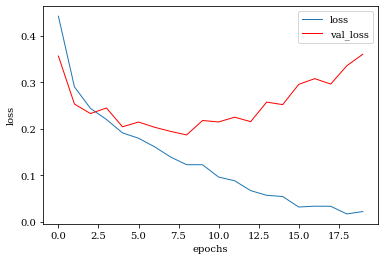

In [0]:
# モデルの評価
## 検証データの誤差の可視化
loss = hist['loss']
val_loss = hist['val_loss']

fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss, linewidth=1,
             label='loss')
plt.plot(range(len(val_loss)), val_loss,
             color='red', linewidth=1,
             label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [0]:
# 予測
test_loss = 0.
test_acc = 0.

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
        test_loss,
        test_acc
))

test_loss: 0.376, test_acc: 0.923


In [0]:
# CIFAR-10以外の画像で試してみる
sample_images = [cv2.imread("/content/drive/My Drive/study/CNN/dataset/CIFAR10/sample_{}.jpg".format(i)) for i in range(10)]
sample_class = [1,1,1,1,1,0,0,0,0,0]

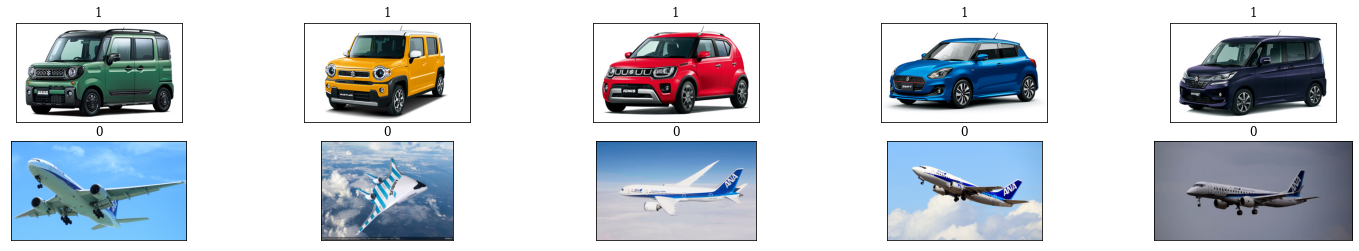

In [0]:
fig = plt.figure(figsize=(25, 4))
for idx in range(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(cv2.cvtColor(sample_images[idx], cv2.COLOR_BGR2RGB))
    ax.set_title(sample_class[idx])

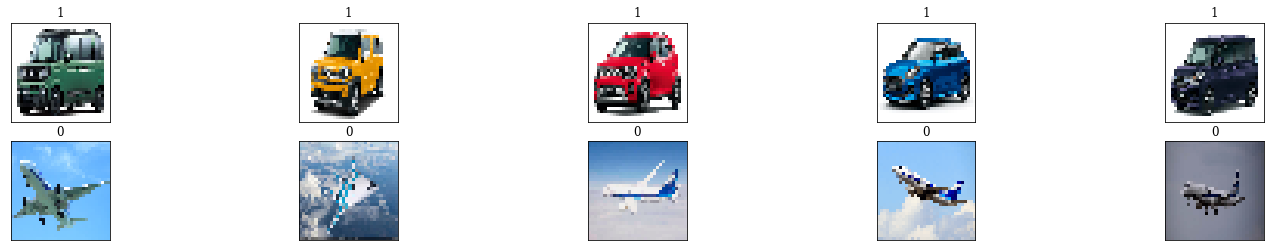

In [0]:
sample_images_resize = [cv2.resize(img, (32,32)) for img in sample_images]
fig = plt.figure(figsize=(25, 4))
for idx in range(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(cv2.cvtColor(sample_images_resize[idx], cv2.COLOR_BGR2RGB))
    ax.set_title(sample_class[idx])

In [0]:
input_dataset = MyDataset(sample_images_resize, sample_class, transform)
input_dataloader = DataLoader(input_dataset)

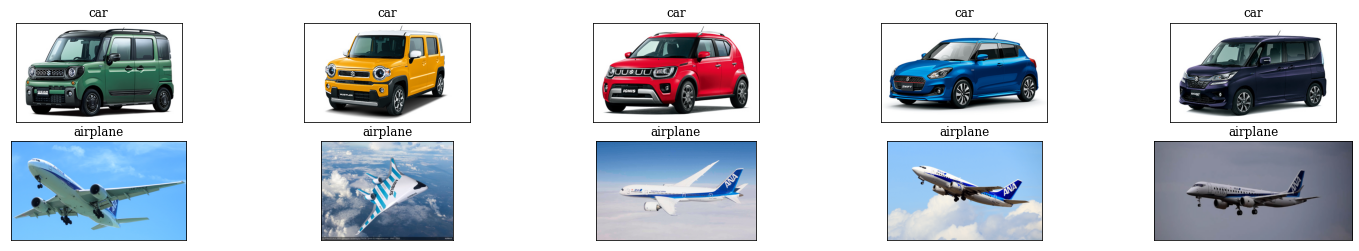

In [0]:
# 予測
result_class = []
for data, label in input_dataloader:
    x = data.to(device)

    model.eval()  # モデルを評価モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    if preds.argmax(dim=-1) == 0:
        result_class.append("airplane")
    else:
        result_class.append("car")

# 出力
fig = plt.figure(figsize=(25, 4))
for idx in range(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(cv2.cvtColor(sample_images[idx], cv2.COLOR_BGR2RGB))
    ax.set_title(result_class[idx])